## Data Preprocessing (with the extraction of concepts from NOTEEVENTS)

### Libraries

In [1]:
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt

import medspacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

from icdmappings import Mapper

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Exploratory Data Analysis (EDA)

In [2]:
# Read the NOTEEVENTS and PATIENTS tables
note = pd.read_csv(
    "data/NOTEEVENTS.csv",
    dtype={"SUBJECT_ID": str, "HADM_ID": str, "CATEGORY": str,"CHARTDATE": str, "TEXT": str},
    parse_dates=["CHARTDATE"],
    infer_datetime_format=True
)

patient = pd.read_csv(
    "data/PATIENTS.csv",
    dtype={"SUBJECT_ID": str, "GENDER": str, "DOB": str, "DOD": str, "DOD_HOSP": str, "DOD_SSN": str},
    parse_dates=["DOB", "DOD", "DOD_HOSP", "DOD_SSN"],
    infer_datetime_format=True,
)

In [3]:
print(note.shape)
note.head(5)

(2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [4]:
print(patient.shape)
patient.head(5)

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
2,236,251,M,2090-03-15,NaT,NaT,NaT,0
3,237,252,M,2078-03-06,NaT,NaT,NaT,0
4,238,253,F,2089-11-26,NaT,NaT,NaT,0


In [5]:
# Select only Discharge Summary notes written as Reports
note_filtered = note[(note['CATEGORY'] == 'Discharge summary') & (note['DESCRIPTION'] == 'Report')]
# Convert the 'SUBJECT_ID' column of the 'note_filtered' dataframe to integer type
note_filtered['SUBJECT_ID'] = note_filtered['SUBJECT_ID'].astype(int)
# Remove any notes with errors
note_filtered = note_filtered[note_filtered['ISERROR'] != 1]
# Remove notes with missing values
note_filtered = note_filtered.dropna(subset=["SUBJECT_ID", "HADM_ID", "TEXT"])
# Calculate the number of tokens for each note and select only notes with at least 1000 tokens
note_filtered['TOKEN_COUNT'] = note_filtered['TEXT'].str.len() / 4

print(note_filtered.nunique())
print("Avg. Token Count: ", note_filtered['TOKEN_COUNT'].mean())

ROW_ID         55177
SUBJECT_ID     41103
HADM_ID        52691
CHARTDATE      27971
CHARTTIME          0
STORETIME          0
CATEGORY           1
DESCRIPTION        1
CGID               0
ISERROR            0
TEXT           55102
TOKEN_COUNT    18558
dtype: int64
Avg. Token Count:  2552.366556717473


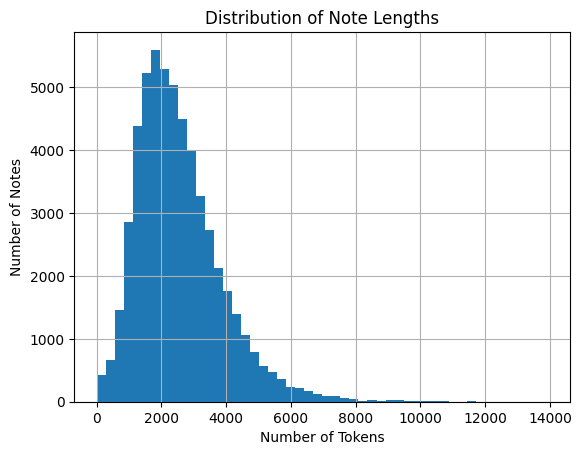

In [6]:
# Plot the distribution of note lengths
note_filtered['TOKEN_COUNT'].hist(bins=50)
plt.title('Distribution of Note Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Notes')
plt.show()

In [17]:
# Filter the 'note_filtered' dataframe to only include notes with at least 1500 and at most 2500 tokens
note_filtered_mod = note_filtered[(note_filtered['TOKEN_COUNT'] >= 1175) & (note_filtered['TOKEN_COUNT'] <= 4850)]
# Drop duplicates based on the 'TEXT' column and update the dataframe
note_filtered_mod.drop_duplicates(subset='TEXT', inplace=True)

# Print the number of unique values for each column
print("Stats: " + str(note_filtered_mod.nunique()) + "\n")

Stats: ROW_ID         45955
SUBJECT_ID     35674
HADM_ID        44958
CHARTDATE      25780
CHARTTIME          0
STORETIME          0
CATEGORY           1
DESCRIPTION        1
CGID               0
ISERROR            0
TEXT           45955
TOKEN_COUNT    13087
dtype: int64



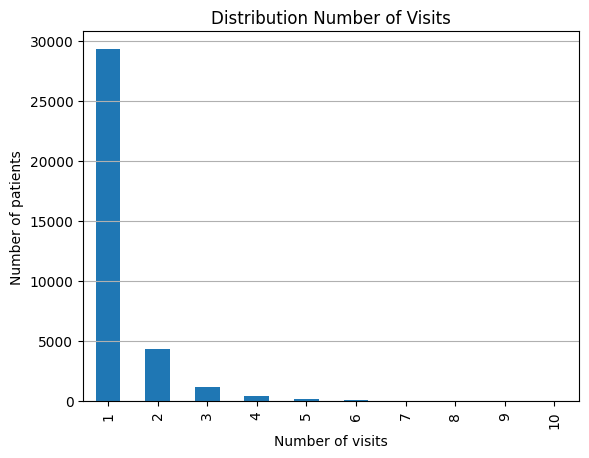

In [18]:
# Count the number of visits per patient
visit_counts = note_filtered_mod.groupby('SUBJECT_ID').size()

# Count the number of patients per number of visits
patients_per_visit_count = visit_counts.value_counts().sort_index()

# Create a bar chart
# plt.figure(figsize=(10, 6))
patients_per_visit_count[:10].plot(kind='bar')
plt.title('Distribution Number of Visits')
plt.xlabel('Number of visits')
plt.ylabel('Number of patients')
plt.grid(axis='y')

# Show the chart
plt.show()

In [19]:
# Group the notes by patient
group_note = note_filtered_mod.groupby("SUBJECT_ID")

# Calculate the number of visits (discharge summaries) for each patient
visits_per_patient = group_note['HADM_ID'].size()

# Filter patients who have at least 2 visits
patients_with_at_least_two_visits = visits_per_patient[visits_per_patient >= 2].index

# Create a new DataFrame containing only patients with at least 2 visits
note_filtered_multiple_visits = note_filtered_mod[note_filtered_mod["SUBJECT_ID"].isin(patients_with_at_least_two_visits)]

# Reset the index of the new DataFrame
note_filtered_multiple_visits = note_filtered_multiple_visits.reset_index(drop=True)
note_filtered_multiple_visits.set_index("ROW_ID", inplace=True)

In [20]:
print(note_filtered_multiple_visits.nunique())
print("Avg. Token Count: ", note_filtered_multiple_visits['TOKEN_COUNT'].mean())

SUBJECT_ID      6353
HADM_ID        15637
CHARTDATE      13093
CHARTTIME          0
STORETIME          0
CATEGORY           1
DESCRIPTION        1
CGID               0
ISERROR            0
TEXT           16634
TOKEN_COUNT     9558
dtype: int64
Avg. Token Count:  2720.1040940242874


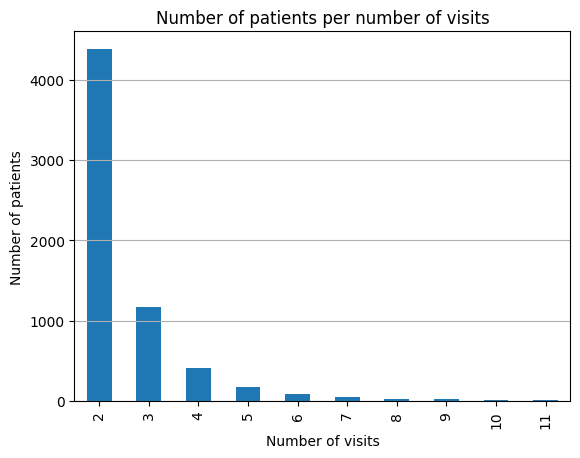

In [21]:
# Count the number of visits per patient
visit_counts = note_filtered_multiple_visits.groupby('SUBJECT_ID').size()

# Count the number of patients per number of visits
patients_per_visit_count = visit_counts.value_counts().sort_index()

# Create a bar chart
# plt.figure(figsize=(10, 6))
patients_per_visit_count[:10].plot(kind='bar')
plt.title('Number of patients per number of visits')
plt.xlabel('Number of visits')
plt.ylabel('Number of patients')
plt.grid(axis='y')

# Show the chart
plt.show()

### Prescriptions Analysis

In [ ]:
# Read the PRESCRIPTIONS table
prescriptions = pd.read_csv(
    "data/PRESCRIPTIONS.csv"
)

In [ ]:
print(prescriptions.shape)
prescriptions.head(5)

(4156450, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


In [ ]:
# Convert the 'SUBJECT_ID' column of the 'prescriptions' dataframe to integer type
prescriptions['SUBJECT_ID'] = prescriptions['SUBJECT_ID'].astype(int)

# Filter the 'prescriptions' dataframe to only include rows where the 'SUBJECT_ID' is in the unique 'SUBJECT_ID' values of the 'note_filtered' dataframe
prescriptions_filtered = prescriptions[prescriptions['SUBJECT_ID'].isin(note_filtered['SUBJECT_ID'].unique().tolist())]

# Print the number of unique 'SUBJECT_ID' values in the 'SUBJECT_ID' column of the 'prescriptions_filtered' dataframe
prescriptions_filtered['SUBJECT_ID'].unique().shape

(37356,)

In [ ]:
# Remove duplicates w.r.t. 'SUBJECT_ID', 'HADM_ID', and 'DRUG'
prescriptions_filtered = prescriptions_filtered.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'DRUG'])

In [ ]:
# Calculate the number of DRUGS per visit
max_drugs_per_visit = prescriptions_filtered.groupby('HADM_ID')['DRUG'].count()
max_drugs_per_visit

HADM_ID
100001    37
100003    23
100006    37
100007    39
100009    49
          ..
199992    29
199993    59
199995    49
199998    54
199999    26
Name: DRUG, Length: 48177, dtype: int64

In [ ]:
# Calculate the max number of DRUGS per visit
max_drugs_per_visit = prescriptions_filtered.groupby('HADM_ID')['DRUG'].count().max()

print("The max number of DRUGS per visit is:", max_drugs_per_visit)

The max number of DRUGS per visit is: 173


### Extraction of sections (OPTIONAL: does not improve the accuracy)

In [29]:
nlp = medspacy.load()

In [381]:
nlp.pipe_names

['medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']

In [41]:
sectionizer = nlp.add_pipe("medspacy_sectionizer")

In [42]:
nlp.pipe_names

['medspacy_pyrush',
 'medspacy_target_matcher',
 'medspacy_context',
 'medspacy_sectionizer']

In [43]:
def section_extraction(text):
    doc = nlp(text)
    i = 0
    note_prep = ""
    for title in doc._.section_titles:
        if str(title).lower() == 'chief complaint:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'history of present illness:' or str(title).lower() == 'history:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'past medical history:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'discharge medications:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'brief hospital course:' or str(title).lower() == 'hospital course:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'discharge diagnoses:':
            note_prep += str(doc._.section_spans[i])
        i += 1

    return note_prep

In [44]:
# Creation of a new column for the cleaned text
note_filtered_multiple_visits['CLEANED TEXT'] = ''

# Iteration over the rows of the DataFrame
total_rows = len(note_filtered_multiple_visits)
for i, (index, row) in enumerate(note_filtered_multiple_visits.iterrows()):
    # Get the text from the desired column (e.g. 'Text')
    text = row['TEXT']
    
    # Extract the sections from the text
    cleaned_text = section_extraction(text)
    
    # Save the cleaned text in the new 'Cleaned Text' column
    note_filtered_multiple_visits.at[index, 'CLEANED TEXT'] = cleaned_text
    
    # Calculate the completion percentage
    percent_complete = ((i + 1) / total_rows) * 100
    # Print the completion percentage overwriting the current line
    sys.stdout.write(f"\rCompleted: {percent_complete:.2f}%")
    sys.stdout.flush()

Completed: 100.00%

### Data Preprocessing: Remove Duplicates, Tokenization and Lemmatization

In [14]:
def tokenize_and_lemmatize(text):
    # Tokenizzazione delle parole
    tokens = word_tokenize(text)
    
    # Inizializzazione del lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Rimozione delle stopwords e simboli
    stop_words = set(stopwords.words('english'))
    symbols = ['[', '*', '+']
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and not re.match(r'^\W+$', token) and not any(symbol in token for symbol in symbols)]
    
    # Lemmatizzazione delle parole
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Riaccorpamento del testo lemmatizzato
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

In [22]:
# Creation of a new column for the lemmatized text
note_filtered_multiple_visits['LEMMATIZED TEXT'] = ''

# Iteration over the rows of the DataFrame
total_rows = len(note_filtered_multiple_visits)
for i, (index, row) in enumerate(note_filtered_multiple_visits.iterrows()):
    # Get the text from the desired column (e.g. 'Text')
    text = row['TEXT']
    
    # Tokenization and lemmatization of the text
    lemmatized_text = tokenize_and_lemmatize(text)
    
    # Save the lemmatized text in the new 'Lemmatized Text' column
    note_filtered_multiple_visits.at[index, 'LEMMATIZED TEXT'] = lemmatized_text
    
    # Calculate the completion percentage
    percent_complete = ((i + 1) / total_rows) * 100
    # Print the completion percentage overwriting the current line
    sys.stdout.write(f"\rCompleted: {percent_complete:.2f}%")
    sys.stdout.flush()

Completed: 100.00%

In [23]:
note_filtered_multiple_visits['LEMMA_TOKEN_COUNT'] = note_filtered_multiple_visits['LEMMATIZED TEXT'].str.len() / 4

print(note_filtered_multiple_visits.nunique())
print("Avg. Token Count: ", note_filtered_multiple_visits['LEMMA_TOKEN_COUNT'].mean())

SUBJECT_ID            6353
HADM_ID              15637
CHARTDATE            13093
CHARTTIME                0
STORETIME                0
CATEGORY                 1
DESCRIPTION              1
CGID                     0
ISERROR                  0
TEXT                 16634
TOKEN_COUNT           9558
LEMMATIZED TEXT      16625
LEMMA_TOKEN_COUNT     8404
dtype: int64
Avg. Token Count:  2074.0603583022726


### NER + EL with MedCAT

In [33]:
from medcat.cat import CAT
from medcat.cdb import CDB
from medcat.vocab import Vocab
from medcat.meta_cat import MetaCAT

In [34]:
DATA_DIR = "./data_umls/"
vocab_path = DATA_DIR + "vocab.dat"
cdb_path = DATA_DIR + "cdb.dat"

In [35]:
# Create and load the CDB (Concept Database)
cdb = CDB.load(cdb_path)

# Create and load the Vocabulary
vocab = Vocab.load(vocab_path)

# Load model for MetaAnnotations (optional)
mc_status = MetaCAT.load("./data_umls/meta_Status/")

In [36]:
# Create CAT - the main class from medcat used for concept annotation
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab, meta_cats=[mc_status])

In [37]:
# Detect only the following entity:
    # bpoc|T023|Body Part, Organ, or Organ Component
    # lbtr|T034|Laboratory or Test Result
    # patf|T046|Pathologic Function
    # dsyn|T047|Disease or Syndrome
    # mobd|T048|Mental or Behavioral Dysfunction
    # lbpr|T059|Laboratory Procedure
    # diap|T060|Diagnostic Procedure
    # topp|T061|Therapeutic or Preventive Procedure
    # phsu|T121|Pharmacologic Substance ---> SE LO AGGIUNGO MI METTE ANCHE ALTRA ROBA TIPO VITAMINE, ENZIMI, ETC.
    # sosy|T184|Sign or Symptom

type_ids_filter = ['T047','T184']
cui_filters = set()
for type_ids in type_ids_filter:
    cui_filters.update(cat.cdb.addl_info['type_id2cuis'][type_ids])
cat.cdb.config.linking['filters']['cuis'] = cui_filters

In [38]:
import sys
from tqdm import tqdm

# Initialize an empty list to store the extracted entities
entities_lemma = [] 
total_rows = len(note_filtered_multiple_visits)

# Use tqdm to create a progress bar
for i, row in tqdm(enumerate(note_filtered_multiple_visits.index), total=total_rows, desc="Processing Rows"):
    # Extract the named entities from the text in the current row
    ner = cat.get_entities(note_filtered_multiple_visits['LEMMATIZED TEXT'][row])
    # Add the row ID, subject ID, and HADM ID to the named entities dictionary
    ner['row_id'] = row
    ner['subject_id'] = note_filtered_multiple_visits['SUBJECT_ID'][row]
    ner['hadm_id'] = note_filtered_multiple_visits['HADM_ID'][row]
    # Append the named entities to the list
    entities_lemma.append(ner)

Processing Rows: 100%|██████████| 16634/16634 [2:04:39<00:00,  2.22it/s]  


### Saving the concepts obtained into NOTEEVENTS_ICD

In [39]:
mapper = Mapper()

# Example data structure for the dataframe
df_structure = {
    'ROW_ID': [],
    'SUBJECT_ID': [],
    'HADM_ID': [],
    'SEQ_NUM': [],
    #'ICD10_CODE': [],
    'ICD9_CODE': []
}

# Process the data to extract needed information
for record in entities_lemma:
    row_id = record['row_id']
    subject_id = record['subject_id']
    hadm_id = record['hadm_id']
    entities = record['entities']
    seq_num = 1  # Reset sequence number for each record
    icd9_codes = set()  # Initialize a set to store unique ICD-9 codes for each record

    for entity_id, entity in sorted(entities.items()):
        # Read ICD-10 information, if available
        icd10_info = entity.get('icd10', [])
        
        # If ICD-10 information is not empty, append data to the structure
        if icd10_info:
            for icd10 in icd10_info:
                # icd9 to icd10
                # Remove the period from the ICD-10 code
                icd10code_cleaned = icd10['chapter'].replace('.', '')
                icd9 = mapper.map(icd10code_cleaned, source='icd10', target='icd9')
                if icd9 and icd9 not in icd9_codes:
                    df_structure['ROW_ID'].append(row_id)
                    df_structure['SUBJECT_ID'].append(subject_id)
                    df_structure['HADM_ID'].append(hadm_id)
                    df_structure['SEQ_NUM'].append(seq_num)
                    #df_structure['ICD10_CODE'].append(icd10['chapter'])  # Using ICD-10 'chapter' as a placeholder for ICD-9 code
                    df_structure['ICD9_CODE'].append(icd9)  # Using ICD-10 'chapter' as a placeholder for ICD-9 code
                    seq_num += 1  # Increment SEQ_NUM only if icd10_info is not empty and icd9 is unique
                    icd9_codes.add(icd9)  # Add the ICD-9 code to the set of unique codes for the current record
                else:
                    continue
            
# Create the dataframe
noteevents_df = pd.DataFrame(df_structure)

In [45]:
print(noteevents_df.shape)
print('Number of visits: ' + str(len(noteevents_df['HADM_ID'].unique())))
print('Number of patients: ' + str(len(noteevents_df['SUBJECT_ID'].unique())))
print('Number of unique symptoms: ' + str(len(noteevents_df['ICD9_CODE'].unique())))

(334546, 5)
Number of visits: 15637
Number of patients: 6353
Number of unique symptoms: 1204


In [46]:
noteevents_df.to_csv('data/NOTEEVENTS_ICD_EXTRA.csv', sep=",", index=False, header=True)

In [60]:
patient_filtered = patient[patient['SUBJECT_ID'].astype(int).isin(noteevents_df['SUBJECT_ID'].unique())]
patient_filtered


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
3,237,252,M,2078-03-06,NaT,NaT,NaT,0
6,240,256,M,2086-07-31,NaT,NaT,NaT,0
22,628,665,M,2052-05-20,2120-02-04,2120-02-04,NaT,1
31,637,674,F,2113-12-14,2195-02-17,2195-02-17,2195-02-17,1
...,...,...,...,...,...,...,...,...
46491,31816,43991,M,2069-01-27,NaT,NaT,NaT,0
46506,31831,44061,M,2073-09-29,NaT,NaT,NaT,0
46507,31832,44064,M,2115-11-18,NaT,NaT,NaT,0
46513,31838,44083,M,2057-11-15,2114-02-20,2114-02-20,2114-02-20,1


In [61]:
patient_filtered.to_csv('data/PATIENTS_SEL_EXTRA.csv', sep=",", index=False, header=True)